In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F

In [3]:

path = r'lfw'
data_dir = r'lfw/lfw'

In [4]:
#Normalizing, rotating and flipping the images by transforming using pytorch methods.
transformer = torchvision.transforms.Compose(
    [ # Applying Augmentation
        torchvision.transforms.Resize((144,144 )),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomRotation(10),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.5, 0.5, 0.5], std=[0.2, 0.2, 0.2]
        ),
    ]
)
database = ImageFolder(data_dir, transform=transformer)

In [5]:
#Setting the validation size
validation_size = 5
training_size = len(database) - validation_size

In [6]:
#Splitting data in test and train dataset
trainset, testset = random_split(database, [training_size, validation_size])


In [7]:
#Initializing batch size and creating list of batches in train and test datasets
batch_size = 7
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [8]:
database.classes


['Aaron_Eckhart',
 'Aaron_Guiel',
 'Aaron_Patterson',
 'Aaron_Peirsol',
 'Aaron_Pena',
 'Aaron_Sorkin',
 'Aaron_Tippin',
 'Abdoulaye_Wade']

In [9]:
classes = ('Aaron_Eckhart',
 'Aaron_Guiel',
 'Aaron_Patterson',
 'Aaron_Peirsol',
 'Aaron_Pena',
 'Aaron_Sorkin',
 'Aaron_Tippin',
 'Abdoulaye_Wade')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


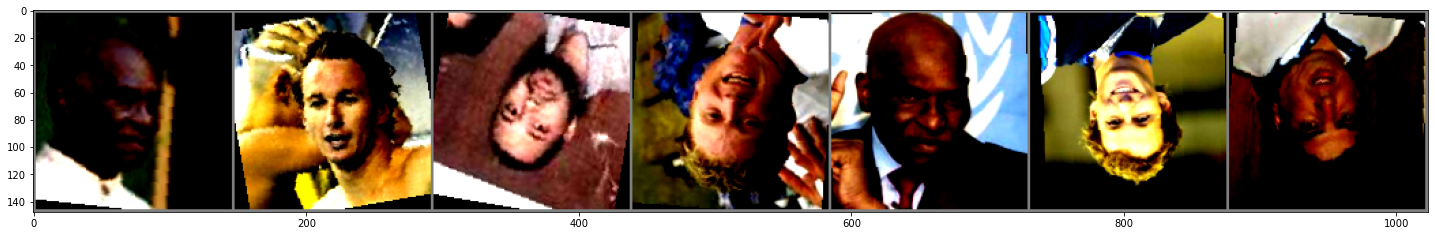

Abdoulaye_Wade Aaron_Peirsol Aaron_Patterson Aaron_Guiel Abdoulaye_Wade Aaron_Peirsol Aaron_Pena


In [10]:
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    fig, ax = plt.subplots(figsize=(25, 25))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [11]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=53, kernel_size=4, stride=2, padding=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(53, 106, kernel_size=4, stride=2, padding=3)
        self.conv3 = nn.Conv2d(106, 212, kernel_size=4, stride=2, padding=3)
        self.fc1 = nn.Linear(212*3*3, 1908)
        self.fc2 = nn.Linear(1908, 8)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net()

In [12]:
import torch.optim as optim
#Initializing learning rate and beta value ; creating optimizer
criterion = nn.CrossEntropyLoss()
lr_dynamic = 0.01
momentum_dynamic = 0.9
optimizer = optim.SGD(net.parameters(), lr=lr_dynamic, momentum=momentum_dynamic)

In [13]:
Epoch_list =[]
Loss_list =[]
for epoch in range(50):
    if epoch >= 10:
      if sum(Loss_list[-5:]) > sum(Loss_list[-10:-5]):
        break
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
       

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            if i==99:
              Epoch_list.append((epoch) + 0.25)
              Loss_list.append(running_loss)
            if i==199:
              Epoch_list.append((epoch) + 0.5)
              Loss_list.append(running_loss)
            if i==299:
              Epoch_list.append((epoch) + 0.75)
              Loss_list.append(running_loss)
            if i==399:
              Epoch_list.append((epoch) + 1)
              Loss_list.append(running_loss)

            running_loss = 0.0

            lr_dynamic = 0.96*lr_dynamic
            optimizer = optim.SGD(net.parameters(), lr=lr_dynamic, momentum=momentum_dynamic) 


print('Finished Training')

Finished Training


<AxesSubplot:xlabel='Batch-Epoch'>

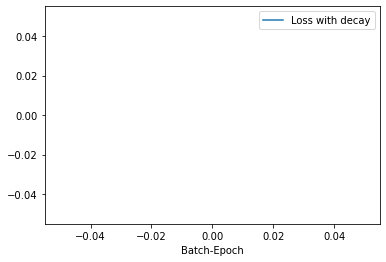

In [14]:
#Plotting the graphs epoch vs loss
loss_df = pd.DataFrame(data={'Batch-Epoch': Epoch_list, 
                        'Loss with decay': Loss_list})
fig, ax = plt.subplots() # Create the figure and axes object

loss_df.plot(x = 'Batch-Epoch', y = 'Loss with decay', ax = ax) 

<AxesSubplot:xlabel='Batch-Epoch'>

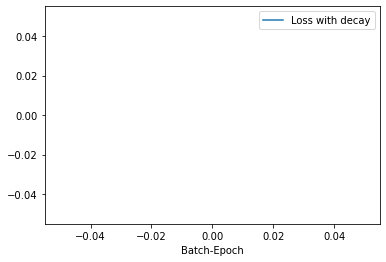

In [15]:
#Plotting the graphs epoch vs loss
loss_df = pd.DataFrame(data={'Batch-Epoch': Epoch_list, 
                        'Loss with decay': Loss_list})
fig, ax = plt.subplots() # Create the figure and axes object

loss_df.plot(x = 'Batch-Epoch', y = 'Loss with decay', ax = ax) 

In [16]:
#Saving the model
path_net = path + r'\model.pth'
torch.save(net.state_dict(), path_net)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


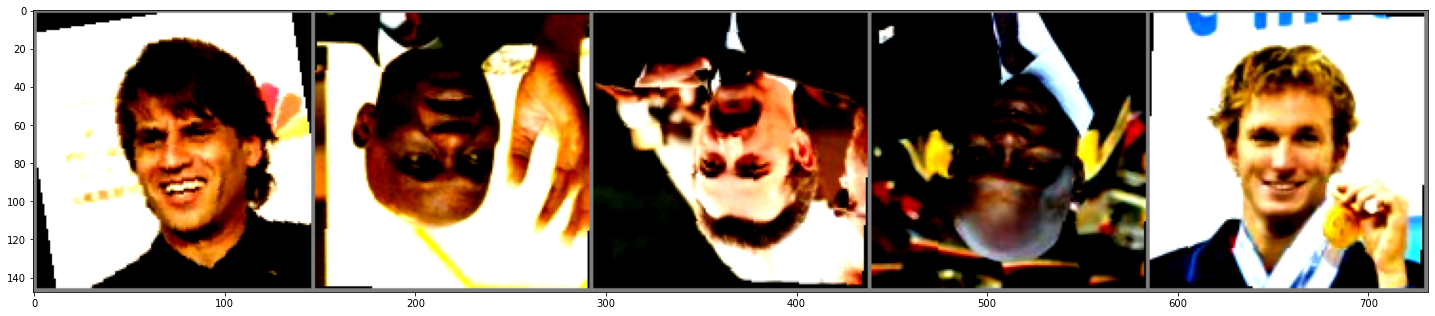

GroundTruth:  Aaron_Sorkin Abdoulaye_Wade Aaron_Tippin Abdoulaye_Wade Aaron_Peirsol


In [17]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(5)))

In [18]:
net = Net()
net.load_state_dict(torch.load(path_net))

<All keys matched successfully>

In [19]:
outputs = net(images)

In [20]:
#Sample predictions
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(3)))

Predicted:  Abdoulaye_Wade Abdoulaye_Wade Aaron_Guiel


In [26]:
#Series and dataframes to store actual and predicted values.
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the train images: {100 * correct // total} %')

Accuracy of the network on the train images: 80 %


In [32]:
#Series and dataframes to store actual and predicted values.
test_results = pd.DataFrame(columns = ['Actual_Image','Predicted_Image'])
Actual_Image= pd.Series(name='Actual_Image',dtype = str)
Predicted_Image= pd.Series(name='Predicted_Image',dtype = str)
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        Actual_Image = pd.concat([Actual_Image, pd.Series(labels.tolist(), name='Actual_Image')], ignore_index=True)
        Predicted_Image = pd.concat([Predicted_Image, pd.Series(predicted.tolist(), name='Predicted_Image')], ignore_index=True)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 500 test images: {100 * correct // total} %')


Accuracy of the network on the 500 test images: 60 %


In [33]:
test_results = pd.concat([Actual_Image,Predicted_Image], axis = 1)
'''
'Aaron_Eckhart',
 'Aaron_Guiel',
 'Aaron_Patterson',
 'Aaron_Peirsol',
 'Aaron_Pena',
 'Aaron_Sorkin',
 'Aaron_Tippin',
 'Abdoulaye_Wade'
'''
test_results['Actual_Image']  = test_results['Actual_Image'].map({0:'Aaron_Eckhart',1: 'Aaron_Guiel',2: 'Aaron_Patterson', 3: 'Aaron_Peirsol', 4:'Aaron_Pena', 5:'Aaron_Sorkin',6:'Aaron_Tippin',7:'Abdoulaye_Wade'})
test_results['Predicted_Image'] = test_results['Predicted_Image'].map({0:'Aaron_Eckhart',1: 'Aaron_Guiel',2: 'Aaron_Patterson', 3: 'Aaron_Peirsol', 4:'Aaron_Pena', 5:'Aaron_Sorkin',6:'Aaron_Tippin',7:'Abdoulaye_Wade'})
display(test_results)

,Actual_Image,Predicted_Image
0,Aaron_Sorkin,Abdoulaye_Wade
1,Abdoulaye_Wade,Abdoulaye_Wade
2,Aaron_Tippin,Aaron_Peirsol
3,Abdoulaye_Wade,Abdoulaye_Wade
4,Aaron_Peirsol,Aaron_Peirsol


In [34]:
print("Confusion matrix with true and predicted Name of people:")
display(pd.crosstab(test_results['Actual_Image'].squeeze(), test_results['Predicted_Image'].squeeze(), rownames=['True'], colnames=['Predicted'], margins=True))

Confusion matrix with true and predicted Name of people:


Predicted,Aaron_Peirsol,Abdoulaye_Wade,All
True,,,
Aaron_Peirsol,1,0,1
Aaron_Sorkin,0,1,1
Aaron_Tippin,1,0,1
Abdoulaye_Wade,0,2,2
All,2,3,5


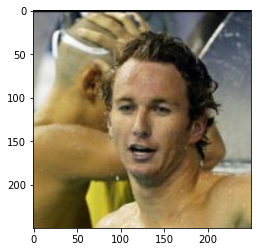

[[1.4247840e-04 8.2078474e-03 9.6593221e-04 9.9953308e+01 3.3957273e-04
  5.4773979e-04 3.1814187e-05 3.6465619e-02]]
Aaron_Eckhart   :    0 %
Aaron_Guiel     :    0 %
Aaron_Patterson :    0 %
Aaron_Peirsol   :    100 %
Aaron_Pena      :    0 %
Aaron_Sorkin    :    0 %
Aaron_Tippin    :    0 %
Abdoulaye_Wade  :    0 %


 Final Predicted image :  AARON_PEIRSOL


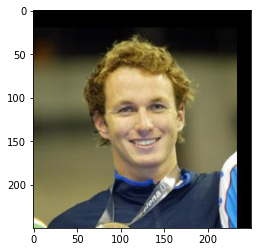

[[66.3338      9.885368    1.4836133  11.49235     0.5973009   9.0402775
   0.51835805  0.64892906]]
Aaron_Eckhart   :    66 %
Aaron_Guiel     :    10 %
Aaron_Patterson :    1 %
Aaron_Peirsol   :    11 %
Aaron_Pena      :    1 %
Aaron_Sorkin    :    9 %
Aaron_Tippin    :    1 %
Abdoulaye_Wade  :    1 %


 Final Predicted image :  AARON_ECKHART


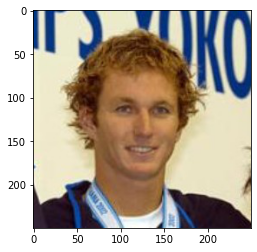

[[3.7716043e-05 2.8450240e-03 5.9964656e-05 9.9337761e+01 8.5302665e-05
  7.6321870e-05 4.6649884e-06 6.5915132e-01]]
Aaron_Eckhart   :    0 %
Aaron_Guiel     :    0 %
Aaron_Patterson :    0 %
Aaron_Peirsol   :    99 %
Aaron_Pena      :    0 %
Aaron_Sorkin    :    0 %
Aaron_Tippin    :    0 %
Abdoulaye_Wade  :    1 %


 Final Predicted image :  AARON_PEIRSOL


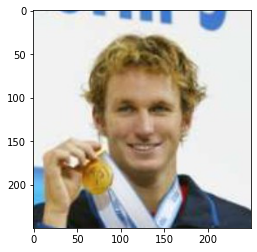

[[1.7942232e-01 9.5837622e+00 3.4898667e+00 8.1989983e+01 1.9084321e-02
  1.2035022e-02 1.7929504e-03 4.7240605e+00]]
Aaron_Eckhart   :    0 %
Aaron_Guiel     :    10 %
Aaron_Patterson :    3 %
Aaron_Peirsol   :    82 %
Aaron_Pena      :    0 %
Aaron_Sorkin    :    0 %
Aaron_Tippin    :    0 %
Abdoulaye_Wade  :    5 %


 Final Predicted image :  AARON_PEIRSOL


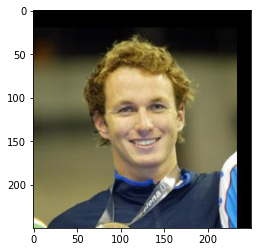

[[71.10821     5.4992123   1.5439875   6.7304125   0.62622625 13.182417
   0.64890707  0.66061854]]
Aaron_Eckhart   :    71 %
Aaron_Guiel     :    5 %
Aaron_Patterson :    2 %
Aaron_Peirsol   :    7 %
Aaron_Pena      :    1 %
Aaron_Sorkin    :    13 %
Aaron_Tippin    :    1 %
Abdoulaye_Wade  :    1 %


 Final Predicted image :  AARON_ECKHART


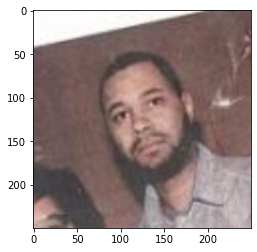

[[2.0092916e-01 9.6403891e-01 9.8724785e+01 5.7936320e-03 8.8715935e-03
  1.9077359e-02 4.8781224e-03 7.1631618e-02]]
Aaron_Eckhart   :    0 %
Aaron_Guiel     :    1 %
Aaron_Patterson :    99 %
Aaron_Peirsol   :    0 %
Aaron_Pena      :    0 %
Aaron_Sorkin    :    0 %
Aaron_Tippin    :    0 %
Abdoulaye_Wade  :    0 %


 Final Predicted image :  AARON_PATTERSON


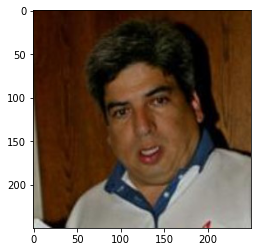

[[ 6.55494    8.519485   9.807542   2.6717706 16.212929   4.2633214
   3.5148215 48.455196 ]]
Aaron_Eckhart   :    7 %
Aaron_Guiel     :    9 %
Aaron_Patterson :    10 %
Aaron_Peirsol   :    3 %
Aaron_Pena      :    16 %
Aaron_Sorkin    :    4 %
Aaron_Tippin    :    4 %
Abdoulaye_Wade  :    48 %


 Final Predicted image :  ABDOULAYE_WADE


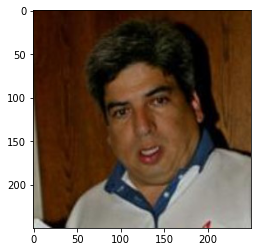

[[ 5.9796324 13.022873  14.052841   2.808897  10.147866   4.1450844
   3.6428735 46.19994  ]]
Aaron_Eckhart   :    6 %
Aaron_Guiel     :    13 %
Aaron_Patterson :    14 %
Aaron_Peirsol   :    3 %
Aaron_Pena      :    10 %
Aaron_Sorkin    :    4 %
Aaron_Tippin    :    4 %
Abdoulaye_Wade  :    46 %


 Final Predicted image :  ABDOULAYE_WADE


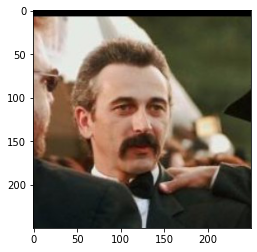

[[ 9.398787  41.207005   4.7260838  7.776777   1.3854288  2.1705868
   0.6380649 32.69726  ]]
Aaron_Eckhart   :    9 %
Aaron_Guiel     :    41 %
Aaron_Patterson :    5 %
Aaron_Peirsol   :    8 %
Aaron_Pena      :    1 %
Aaron_Sorkin    :    2 %
Aaron_Tippin    :    1 %
Abdoulaye_Wade  :    33 %


 Final Predicted image :  AARON_GUIEL


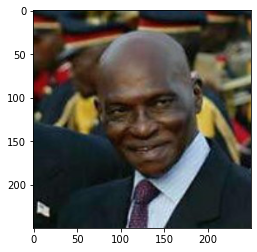

[[11.097833  12.3948965  8.411047  10.351028  15.290626  10.5134535
   6.2449517 25.696167 ]]
Aaron_Eckhart   :    11 %
Aaron_Guiel     :    12 %
Aaron_Patterson :    8 %
Aaron_Peirsol   :    10 %
Aaron_Pena      :    15 %
Aaron_Sorkin    :    11 %
Aaron_Tippin    :    6 %
Abdoulaye_Wade  :    26 %


 Final Predicted image :  ABDOULAYE_WADE


In [35]:
import tkinter as tk
from tkinter import filedialog
from tkinter.filedialog import askopenfile
from PIL import Image, ImageTk
from tkinter import *

win = tk.Tk()
win.attributes('-fullscreen', True)

win['background'] = '#110e1b'

font = ('georgia', 22, 'bold')
title = Label(win, text='ANN Face Recognition                                                                                                               ')
title.config(bg='#110e1b', fg='#68b0ab')
title.config(font=font)
title.config(height=3, width=120)
title.place(x=5, y=5)

font1 = ('times', 12, 'bold')
text = Text(win, height=20, width=80)

myscrollbar=Scrollbar(text)
text.configure(yscrollcommand=myscrollbar.set)
text.place(x=50, y=120)
text.config(font=font1)

font = ('black', 10, 'bold')
Imagetext = Label(win, text='IMAGE DISPLAY')
Imagetext.config(bg='#68b0ab', fg='white')
Imagetext.config(font=font)
Imagetext.config(height=3, width=20)
Imagetext.place(x=1000, y=530)

font = ('black', 10, 'bold')
Imagetext2 = Label(win, text='**** PREDICTION ****')
Imagetext2.config(bg='#68b0ab', fg='white')
Imagetext2.config(font=font)
Imagetext2.config(height=3, width=20)
Imagetext2.place(x=1320, y=120)

font1 = ('times',15, 'bold')
predict = Text(win, height=3, width=20)
predict.place(x=1320, y=200)
predict.config(font=font1)


frame = Frame(win, width=500, height=400, bg="#faf3dd", colormap="new")
frame.pack()
frame.place(x=800, y=120)

from PIL import Image
from torch.autograd import Variable
import matplotlib.image as mpimg

def get_probabilities(image):
  imgplot = plt.imshow(image)
  plt.show()
  image = transformer(image)
  image = image.float()
  image = Variable(image, requires_grad=True)
  image = image.unsqueeze(0) 
  outputs = net(image)
  _, predicted = torch.max(outputs.data, 1)
  sm = torch.nn.Softmax(dim = 1)
  probabilities = sm(outputs) 
  probabilities = probabilities.detach().numpy()
  print(probabilities*100) 
  text.delete('1.0', END)
  predict.delete('1.0',END)
  predict.insert(END, (classes[predicted.tolist()[0]]).upper())
  for i,j in enumerate(probabilities[0]):
    str_display = classes[i].ljust(15, ' ')  + ':   ' +  str(round(j*100,4)) + '%\n'
    text.insert(END, str_display)
    print(classes[i].ljust(15, ' ') ,':   ', round(j*100,),'%')
  print('\n\n Final Predicted image : ', classes[predicted.tolist()[0]].upper())


def upload_file():
    global img
    for widget in frame.winfo_children():
        widget.destroy()
    f_types = [('Jpg Files', '*.jpg'),('Jpeg Files', '*.jpeg'),('PNG Files', '*.png')]
    filename = filedialog.askopenfilename(filetypes=f_types)
    img=Image.open(filename)
    image2= img
    get_probabilities(img)
    img_resized=img.resize((500,400)) 
    img=ImageTk.PhotoImage(img_resized)
    label = Label(frame, image = img)
    label.pack()


def close():
   win.destroy()

b1 = tk.Button(win,text='Upload \nPhoto', width=20,command = lambda:upload_file())
b1.config(font=('times', 12, 'bold'))
b1.place(x=1000, y=600)

font = ('black', 10, 'bold')
probabilities = Label(win, text='Probabilities of each class',bg='#68b0ab')
probabilities.config(bg='#68b0ab', fg='white')
probabilities.config(font=('times', 12, 'bold'))
probabilities.config(height=3, width=20)
probabilities.place(x=300, y=550)

exitButton = Button(win, text="Exit", command=close)
exitButton.place(x=1200, y=600)
exitButton.config(font=('times', 12, 'bold'))

win.mainloop()  